<a href="https://colab.research.google.com/github/Ephraimosse9/Pytorch-course-on-UDEMY--Notes-and-Codes/blob/main/FashionMNIST_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
import torch.utils.data
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
!pip install torchmetrics
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix
import pandas as pd
import pathlib
from tqdm.auto import tqdm
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
#Downloading the FahionMNIST dataset
train_data = datasets.FashionMNIST(root= "data",
                                   train=True,
                                   download= True,
                                   transform= ToTensor()
                                   )

test_data = datasets.FashionMNIST(root= "data",
                                   train=False,
                                   download= True,
                                   transform= ToTensor()
                                   )

In [ ]:
#Checking length of train and test data
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
#Checking how many classes are in the dataset and their names
class_names = train_data.classes

In [ ]:
#Printing the Image and Label, especially the image shape
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'T-shirt/top')

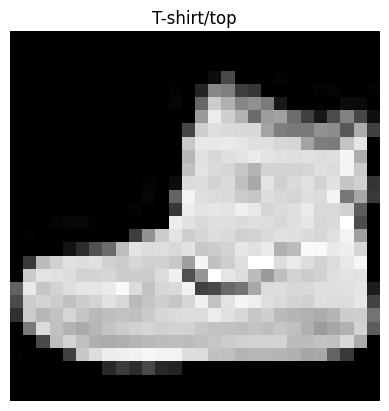

In [ ]:
#Visualizing Images in the the train data
plt.imshow(image.squeeze(), cmap= "gray")
plt.axis(False)
plt.title(class_names[0])

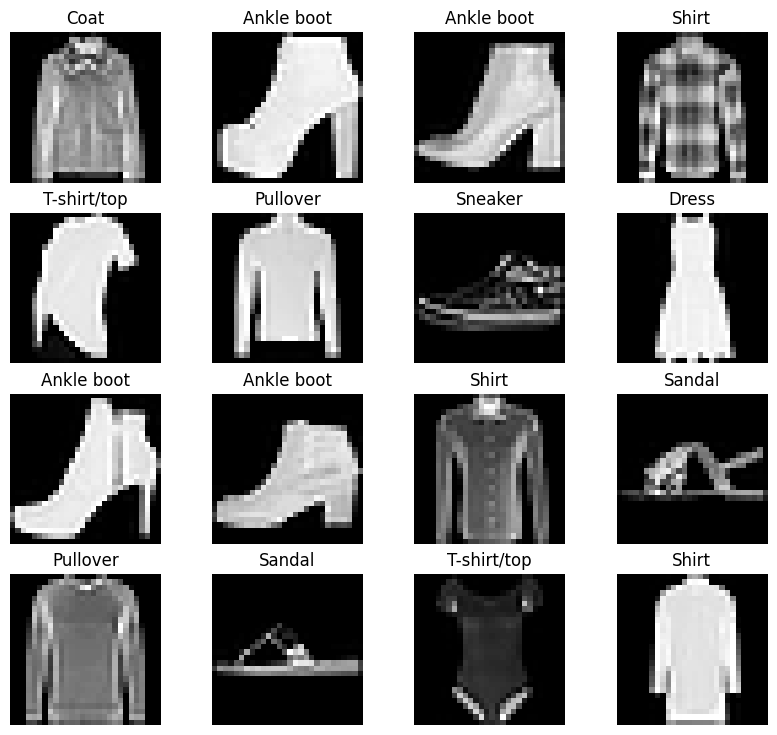

In [ ]:
#Visualizing our train data in batches

fig = plt.figure(figsize=(10,9))
row, col = 4,4

for i in range(row*col):
  idx = torch.randint(0, len(train_data), size=[1]).item()
  img, lab = train_data[idx]
  fig.add_subplot(row, col, i+1)
  plt.imshow(img.squeeze(), cmap= "gray")
  plt.title(class_names[lab])
  plt.axis(False)

In [ ]:
#Loading Our data into train batch sizes, and test batches

train_loaded_data = DataLoader(
    dataset= train_data,
    batch_size= 32,
    shuffle= True
)

test_loaded_data = DataLoader(
    dataset= test_data,
    batch_size= 32,
    shuffle= False
)

In [ ]:
#From our loaded batch data, lets see how many labels and images are inside.
train_loaded_data_image_batches, train_loaded_data_label_batches = next(iter(train_loaded_data))
len(train_loaded_data_image_batches), len(train_loaded_data_image_batches)

(32, 32)

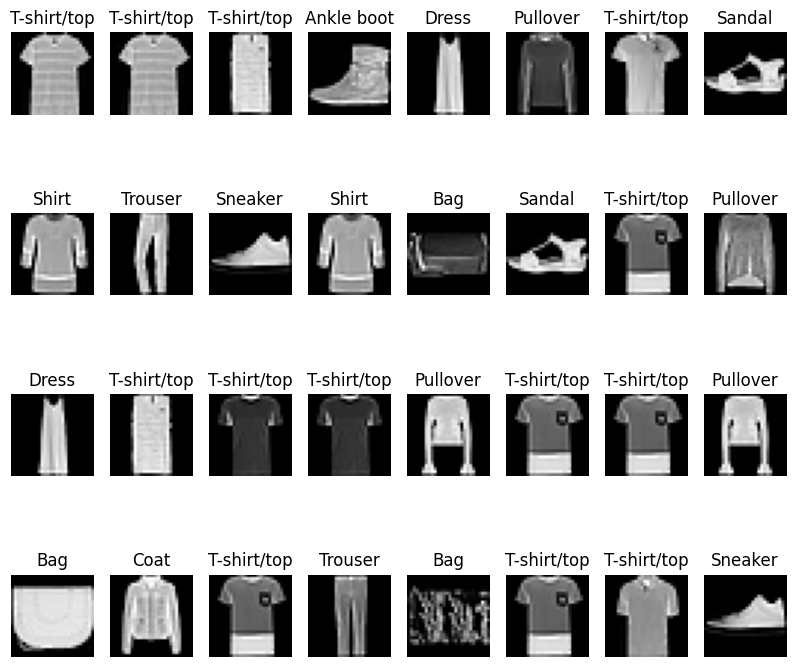

In [ ]:
#Now lets visualize ourloaded train images and test images, the whole 32 images
fig = plt.figure(figsize=(10,9))
row, col = 4,8
for i in range(row*col):
  idx = torch.randint(0, len(train_loaded_data_image_batches), size= [1]).item()
  imag, labs = train_loaded_data_image_batches[idx], train_loaded_data_label_batches[idx]
  fig.add_subplot(row, col, i+1)
  plt.imshow(imag.squeeze(), cmap= "gray")
  plt.title(class_names[labs])
  plt.axis(False)


In [ ]:
#Now lets create our model
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
class FashionModel(nn.Module):
  def __init__(self, input_channel: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv1_block = nn.Sequential(
        nn.Conv2d(in_channels=input_channel, out_channels= hidden_units, kernel_size=3, stride=1, padding=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels= hidden_units, kernel_size=3, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv2_block = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels= hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels= hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv3_block = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels= hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels= hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=1024, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv1_block(x)
    x = self.conv2_block(x)
    x = self.conv3_block(x)
    x = self.classifier(x)

    return x

model_0 = FashionModel(input_channel=1, hidden_units=64, output_shape= len(class_names)).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model_0.parameters(), lr=0.001)
accuracy_fn = Accuracy(task="multiclass", num_classes= len(class_names)).to(device)
confusion_mat = ConfusionMatrix(task="multiclass", num_classes=10).to(device)

In [ ]:
epochs = 10
for epoch in tqdm(range(epochs)):
  train_loss, train_acc = 0,0
  test_loss, test_acc = 0,0

  for image, label in train_loaded_data:
    model_0.train()
    image_train, label_train = image.to(device), label.to(device)
    label_pred = model_0(image_train)
    loss_train = loss_fn(label_pred, label_train)
    acc_train = accuracy_fn(label_pred.argmax(dim=1), label_train)
    train_loss += loss_train
    train_acc += acc_train

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

  train_loss /= len(train_loaded_data)
  train_acc /= len(train_loaded_data)

  model_0.eval()
  with torch.inference_mode():
    for image, label in test_loaded_data:
      image_test, label_test = image.to(device), label.to(device)
      label_pred_test = model_0(image_test)
      loss_test = loss_fn(label_pred_test, label_test)
      acc_test = accuracy_fn(label_pred_test.argmax(dim=1), label_test)

      test_loss += loss_test
      test_acc += acc_test

    test_loss /= len(test_loaded_data)
    test_acc /= len(test_loaded_data)


  print(f"Epoch: {epoch} | Training Loss: {train_loss: .2f}, Training Accuracy: {train_acc*100: .2f}% | Testing Loss: {test_loss: .2f}, Testing Accuracy: {test_acc*100: .2f}%")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Training Loss:  0.51, Training Accuracy:  80.90% | Testing Loss:  0.37, Testing Accuracy:  86.30%
Epoch: 1 | Training Loss:  0.31, Training Accuracy:  88.49% | Testing Loss:  0.30, Testing Accuracy:  88.98%
Epoch: 2 | Training Loss:  0.26, Training Accuracy:  90.28% | Testing Loss:  0.27, Testing Accuracy:  90.60%
Epoch: 3 | Training Loss:  0.23, Training Accuracy:  91.35% | Testing Loss:  0.25, Testing Accuracy:  91.13%
Epoch: 4 | Training Loss:  0.21, Training Accuracy:  92.35% | Testing Loss:  0.26, Testing Accuracy:  91.09%
Epoch: 5 | Training Loss:  0.19, Training Accuracy:  93.03% | Testing Loss:  0.23, Testing Accuracy:  91.92%
Epoch: 6 | Training Loss:  0.17, Training Accuracy:  93.61% | Testing Loss:  0.23, Testing Accuracy:  91.81%
Epoch: 7 | Training Loss:  0.16, Training Accuracy:  94.17% | Testing Loss:  0.23, Testing Accuracy:  92.13%
Epoch: 8 | Training Loss:  0.15, Training Accuracy:  94.46% | Testing Loss:  0.23, Testing Accuracy:  91.94%
Epoch: 9 | Training

In [ ]:
# Now lets evaluate our Model
test_loss, test_acc = 0,0
model_0.eval()
with torch.inference_mode():
  for X, y in test_loaded_data:
    X, y = X.to(device), y .to(device)
    y_pred = model_0(X)
    loss = loss_fn(y_pred, y)
    acc = accuracy_fn(y_pred.argmax(dim=1), y)
    test_loss += loss
    test_acc += acc
  test_loss /= len(test_loaded_data)
  test_acc /= len(test_loaded_data)

print(f"Model Loss: {test_loss: .2f}, Model Accuracy: {test_acc*100: .2f}%")

Model Loss:  0.25, Model Accuracy:  91.42%


In [ ]:
# Now Lets Visualize our Model

#This will happen in 3 stages
#1st we will create 2 lists of images and Labels, generated at random from the test_data initialized above, before loading

import random
test_samples = []
test_labels = []

for samples, labels in random.sample(list(test_data), k=9):
  test_samples.append(samples)
  test_labels.append(labels)

test_labels

[3, 5, 2, 2, 4, 5, 6, 0, 2]

In [ ]:
# Now we will pass the list of our test_samples into our model and see what labels it would generate
predictions = []
model_0.eval()
with torch.inference_mode():
  for samples in test_samples:
    samples = samples.unsqueeze(dim=0).to(device)
    y_pred = model_0(samples)
    y_pred_prob = y_pred.argmax(dim=1)
    predictions.append(y_pred_prob.cpu())
predictions = torch.cat(predictions).to(device)

predictions

tensor([3, 5, 2, 2, 6, 5, 3, 0, 2], device='cuda:0')

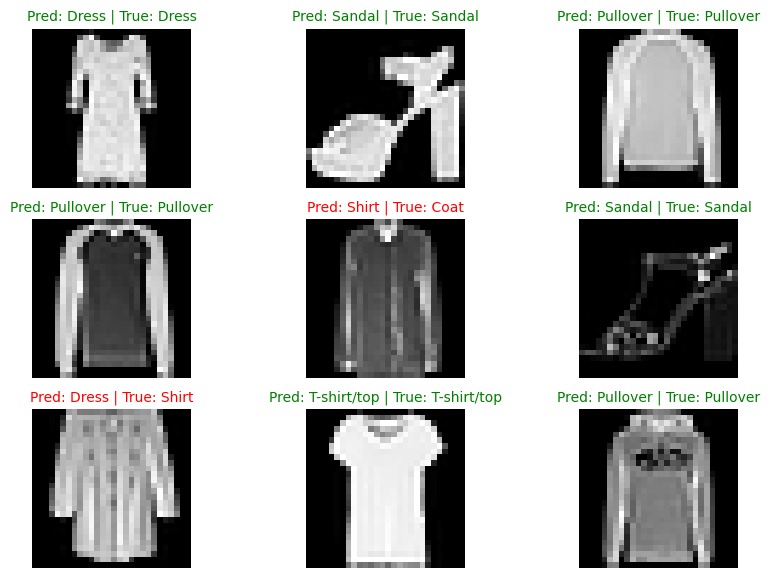

In [ ]:
#Now lets Visualize a set of Images to see the ones it got worng
fig = plt.figure(figsize=(10,7))
row, col = 3,3

for i, samples in enumerate(test_samples):
  fig.add_subplot(row, col, i+1)
  plt.imshow(samples.squeeze(), cmap="gray")
  pred = predictions[i]
  truth = test_labels[i]
  title = f"Pred: {class_names[pred]} | True: {class_names[truth]}"

  if pred == truth:
    plt.title(title, fontsize=10, c="g")
  else:
    plt.title(title, fontsize=10, c="r")

  plt.axis(False)



In [ ]:
#Now we see our model has issue identifying certain things, lets view a confusion matrix to better understand this

y_pred = []
model_0.eval()
for X, y in test_loaded_data:
  X = X.to(device)
  y_predi = model_0(X)
  y_prediction = y_predi.argmax(dim = 1)
  y_pred.append(y_prediction.cpu())

y_pred = torch.cat(y_pred).to(device)
y_pred

tensor([9, 2, 1,  ..., 8, 1, 5], device='cuda:0')

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

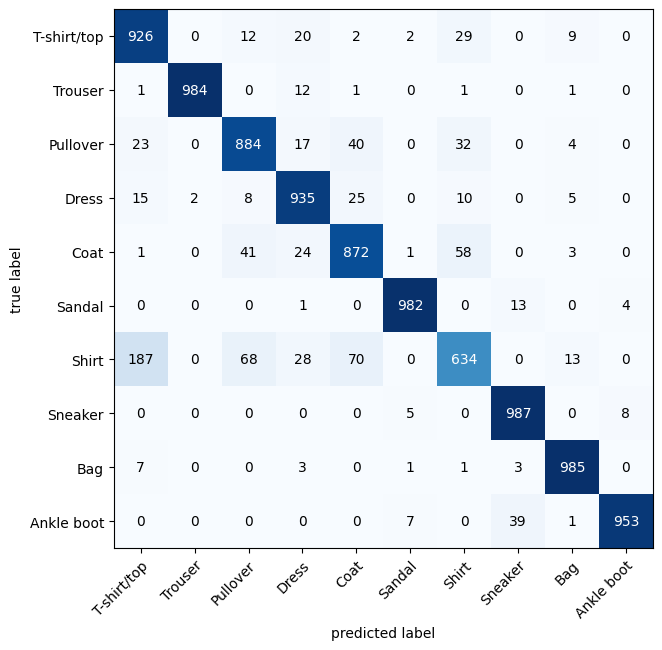

In [ ]:
# Now lets plot our Confusion Matrix
conf_mat = confusion_mat(y_pred, test_data.targets.to(device))

plot_confusion_matrix(conf_mat=conf_mat.cpu().numpy(), figsize=(10,7), class_names=class_names)